## Some Notes:

1. Environment versions: [https://github.com/openai/gym/issues/1280](https://github.com/openai/gym/issues/1280)

   If you look at the atari_env source code, essentially:
    - v0 vs v4: v0 has repeat_action_probability of 0.25 (meaning 25% of the time the previous action will be used instead of the new action), while v4 has 0 (always follow your issued action) 
    - Deterministic: a fixed frameskip of 4, while for the env without Deterministic, frameskip is sampled from (2,5) (code here)
    
   There is also NoFrameskip-v4 with no frame skip and no action repeat stochasticity.
   
2. Frame skipping: [https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/](https://danieltakeshi.github.io/2016/11/25/frame-skipping-and-preprocessing-for-deep-q-networks-on-atari-2600-games/)

   ![](https://danieltakeshi.github.io/assets/breakout_images_max.png)
   
   - Frame-skip of 4
   - For every $4t^{\text{th}}$ frame, max is taken over $4t^{\text{th}}$ and $(4t - 1)^{\text{th}}$ frames.
   - State thus consists of $[\max(f_{t-1}, f_t), \max(f_{t+3}, f_{t+4}), \max(f_{t+7}, f_{t+8}), \max(f_{t+11}, f_{t+12})]$
   - Action is repeated for skipped states

In [1]:
import numpy as np
import torch
from torchvision import transforms
from PIL import Image
import gym
import matplotlib.pyplot as plt

Matplotlib is building the font cache; this may take a moment.


In [2]:
class Preprocessor:
    def __init__(self, agent_history_length=4, interpolation=Image.NEAREST):
        """
        Performs preprocessing steps on raw Atari input. Refer to DQN paper for terminology.
            agent_history_length: Number of frames to stack
            interpolation: Filter used during resize.
                           Refer to - https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-filters
        """
        self.buffer = torch.zeros((agent_history_length, 84, 84))
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.Grayscale(num_output_channels=1),
            transforms.Resize(size=(84, 84), interpolation=interpolation),
            transforms.ToTensor()
        ])
        
        self.to_pil = transforms.ToPILImage()

    def reset(self):
        self.buffer = torch.zeros_like(self.buffer)

    def process(self, frame):
        """
        Process Atari frame and return tensor that can feed into the estimator
        """
        out = self.transform(frame)
        self.buffer[:-1] = self.buffer[1:].clone()
        self.buffer[-1] = out

        return self.buffer.clone()
    
    def visualize_buffer(self):
        n = self.buffer.shape[0]
        fig, ax = plt.subplots(nrows=1, ncols=n, figsize=(12,24))
        for i in range(n):
            ax[i].imshow(self.to_pil(self.buffer[i]), cmap='gray')
            ax[i].axis('off')
        return fig

In [3]:
def frameskip(env, action, skips=4):
    all_reward, all_frames, all_done, all_info = 0, [], False, []
    
    for i in range(skips):
        frame, reward, done, info = env.step(action)
        all_frames.append(frame)
        all_reward += reward
        all_done |= done
        all_info.append(info)
        
        if done:
            break
    
    if len(all_frames) == skips:
        frame = np.maximum(all_frames[-2], all_frames[-1])
    
    else:
        frame = all_frames[-1]
    
    return frame, all_reward, all_done, all_info

### Visualize buffer with random actions

In [14]:
env = gym.make('SpaceInvaddNoFrameskip-v4')

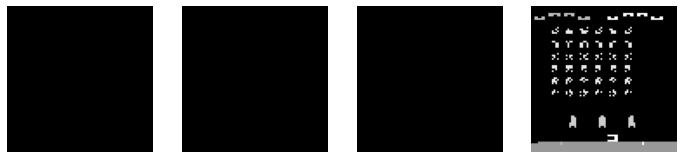

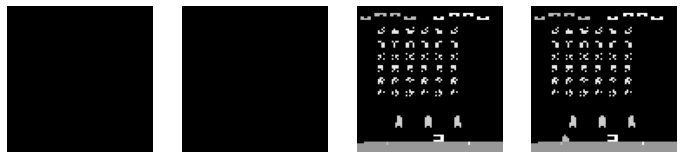

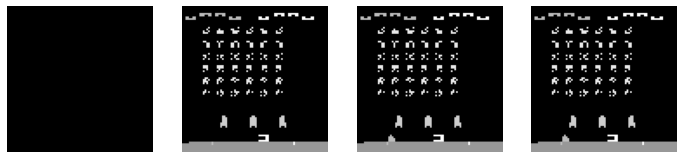

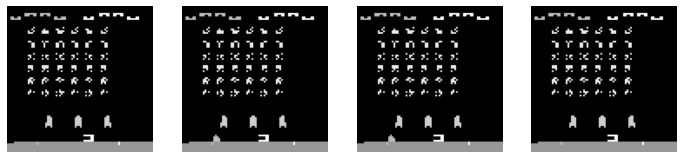

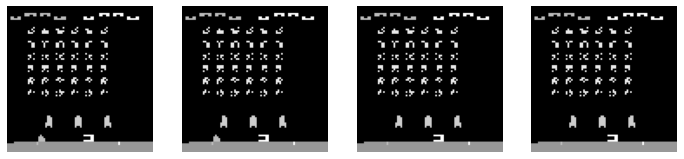

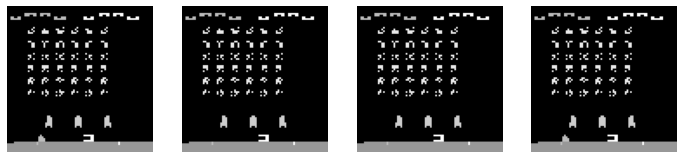

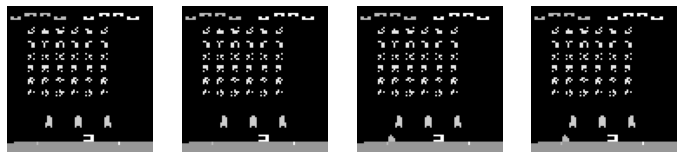

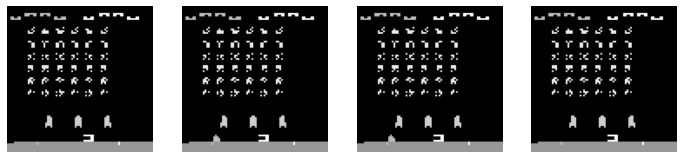

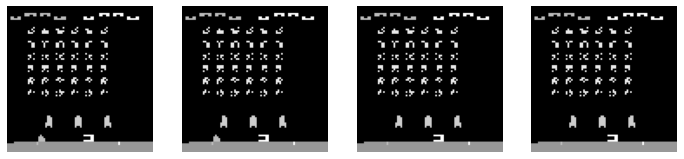

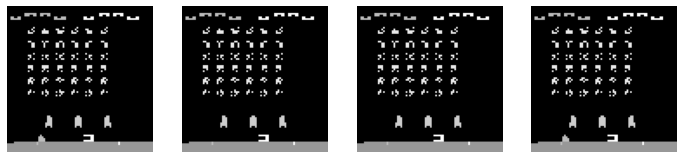

In [16]:
steps = 10
preprocessor = Preprocessor()
state = env.reset()

for step in range(steps):
    buffer = preprocessor.process(state)
    fig = preprocessor.visualize_buffer()
    
    action = env.action_space.sample()
    state, reward, done, info = frameskip(env, action=action)

## Plotting DQN Architecture using TorchViz

In [45]:
import torch.nn as nn
from collections import OrderedDict

class Estimator(nn.Module):
    def __init__(self, num_actions, agent_history_length=4):
        """
        Estimator class; returns Q-values
        """

        super(Estimator, self).__init__()

        self.model = nn.Sequential(OrderedDict([
            # Input: batch x m x 84 x 84
           ("Conv1", nn.Conv2d(in_channels=agent_history_length, out_channels=32, kernel_size=8, stride=4)),
            #nn.BatchNorm2d(32),
            ("ReLU", nn.ReLU()),
            # Input: batch x 32 x 20 x 20
            ("Conv2", nn.Conv2d(in_channels=32, out_channels=64, kernel_size=4, stride=2)),
            #nn.BatchNorm2d(64),
            ("ReLU", nn.ReLU()),
            # Input: batch x 64 x 9 x 9
            ("Conv3", nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1)),
            #nn.BatchNorm2d(64),
            ("ReLU", nn.ReLU()),
            # Input: batch x 64 x 7 x 7
            ("Flatten", nn.Flatten(1)),
            # Input: batch x 3136
            ("FC1", nn.Linear(in_features=3136, out_features=512)),
            ("ReLU", nn.ReLU()),
            # Input: batch x 512
            ("FC2", nn.Linear(in_features=512, out_features=num_actions))
            ]))

        self._initialize_weights()

    def forward(self, x):
        out = self.model(x)
        return out

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight) #Using Kaiming normalization to work well with non-linear function like ReLU.


In [66]:
estimator = Estimator(num_actions=6, agent_history_length=8)

In [67]:
print(estimator)

Estimator(
  (model): Sequential(
    (Conv1): Conv2d(8, 32, kernel_size=(8, 8), stride=(4, 4))
    (ReLU): ReLU()
    (Conv2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (Conv3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (Flatten): Flatten(start_dim=1, end_dim=-1)
    (FC1): Linear(in_features=3136, out_features=512, bias=True)
    (FC2): Linear(in_features=512, out_features=6, bias=True)
  )
)


In [68]:
x = estimator(torch.zeros(32,8,84,84))

In [69]:
from torchviz import make_dot

In [70]:
make_dot(x, params=dict(list(estimator.named_parameters()))).render("dqn_arch", format="png")

'dqn_arch.png'